# Competition goal
`Having graph of people connections, we should model the propagation of marketing campaign influence and get the highest profit of it.`

## Explicit task

You are running the marketing campaign for a brand new pocket device. Initially you can sign contracts with a few people to advertize your gadget among their neigbours. The more "famous" person you are picking the greater price appears in the contract. Contract cost can be calculated as $300\$$ * NN(i), where NN(i) is the number of neigbours of the person i. If at least $18 \%$ a person's neighbors have already been affected, then he/she will also be affected tomorrow. You earn $50\$$ per each affected person. Every day you have to choose whether to sign new contracts or wait. You need time to discuss terms of a contract, so you cannot sign more than 10 contracts on the same day. Your task is to maximize profit of your campaign with an initial budget of $10,000\$$. Your campaign is considered completed after 60 days.

Again, all parameters of the task:\
Budget: $10,000\$$\
Contract cost: $300\$$ * NN(i)\
Income per person: $50\$$
Exposure threshold: 18%\
Contracts limit: 10 per day\
Time limit: 60 days\
A model of society is based on undirected SNAP Facebook network marketing_edges.txt

Evaluation Criteria\
On the leaderboard you will see three scores:\
Profit — calculated as "total amount of money at the end - initial budget". This is the main score.\
Accepted — the total number of accepted people at the end.\
Days — the total duration of your campaign.\
Baselines\
Baselines are calculated as follows:\
Simultaneously sign 10 random contracts on the first day. Decrease the number of contracts if you do not have enough money\
Wait the end of the campaign and calculate your profit.\
Repeat 10000 times\
Baseline for grade 4: beat an average positive profit\
Baseline for grade 6: beat an average + standard deviation positive profit

In [2]:
import numpy as np
import networkx as nx
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cosine
from community_detection import *

# Lets take a look on a graph

In [3]:
file_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/marketing_edges.txt'

In [4]:
edgelist = pd.read_csv(file_url,sep = ' ', header = None)
edgelist = [e for e in list(zip(edgelist[0],edgelist[1]))]

In [5]:
G = nx.from_edgelist(edgelist)

In [6]:
pos = nx.spring_layout(G)

## Graph visualization

<IPython.core.display.Javascript object>


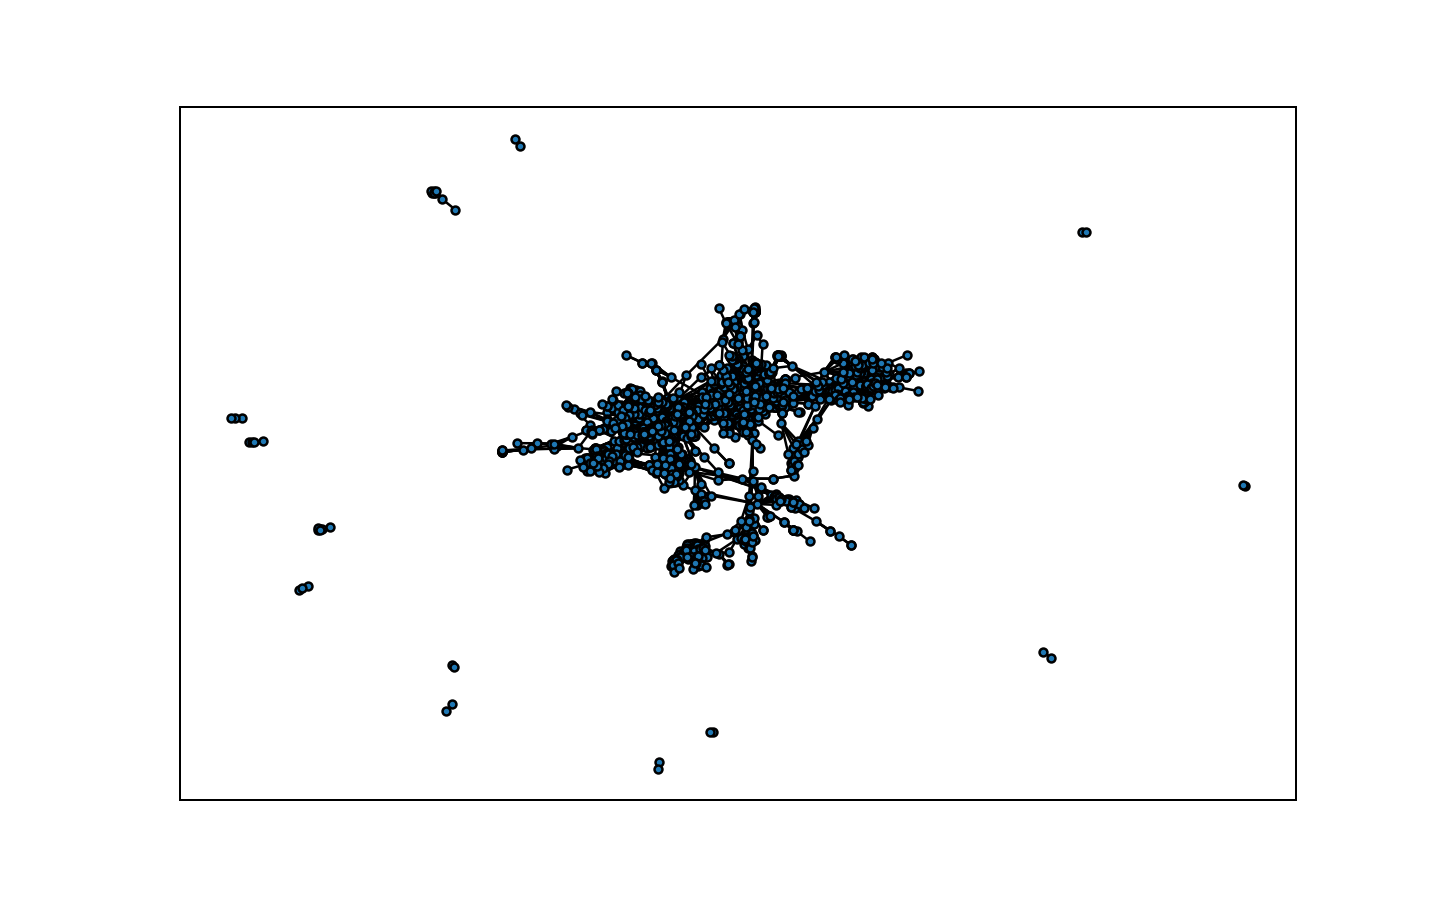

In [7]:
plt.figure(figsize = (8,5))
nx.draw_networkx_nodes(G, pos= pos, node_size = 10, edgecolors = 'black')
nx.draw_networkx_edges(G,pos)

## Giant component visualization 

<IPython.core.display.Javascript object>


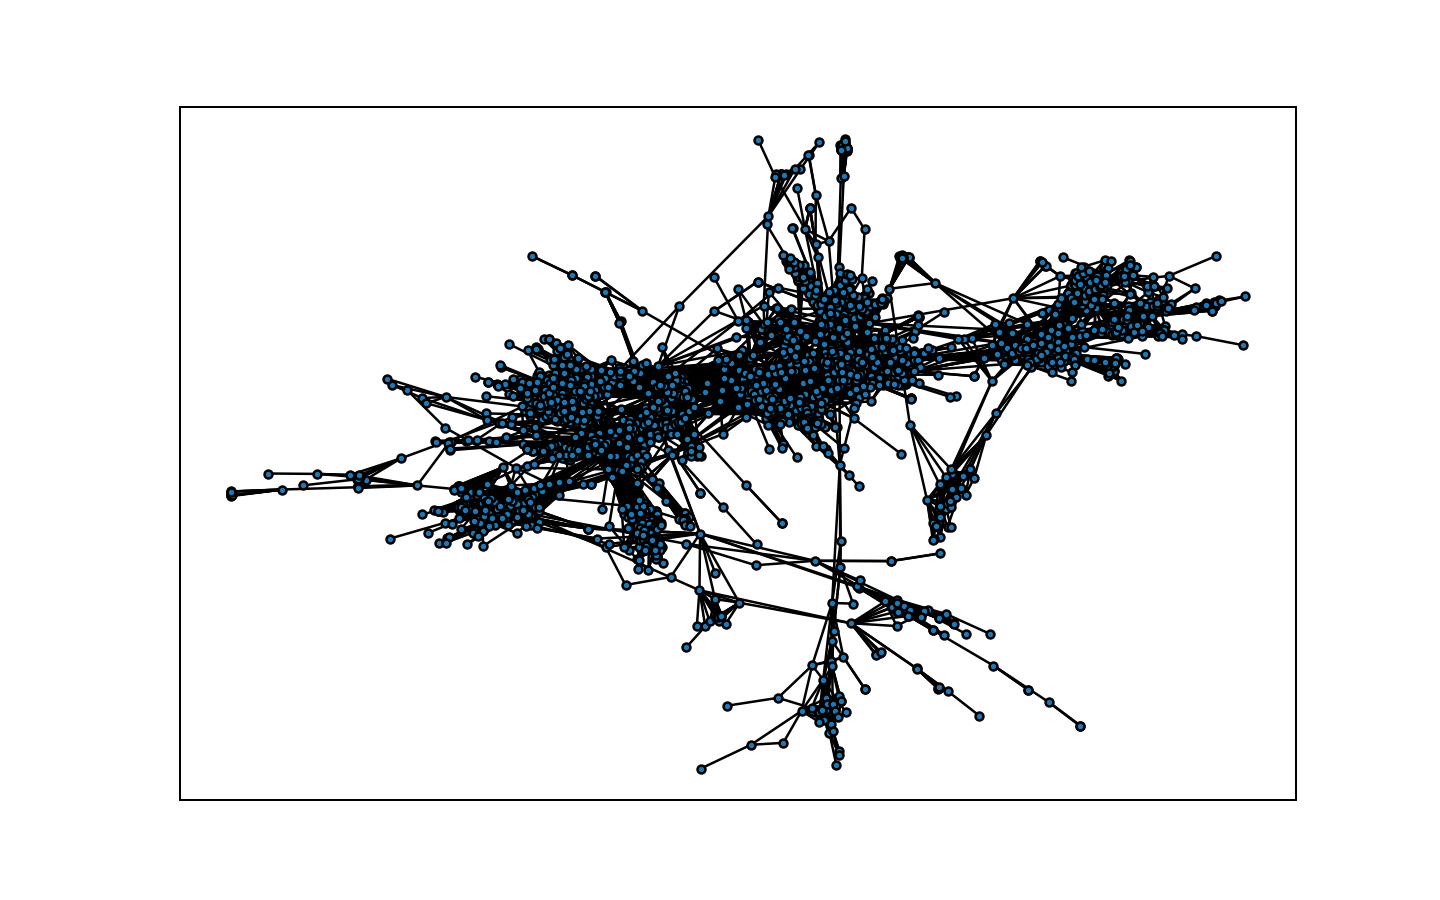

Number of nodes on giant component 3732


In [536]:
G_m = nx.subgraph(G, max(list(nx.connected_components(G)), key = len))
plt.figure(figsize = (8,5))
nx.draw_networkx_nodes(G_m, pos= pos, node_size = 10, edgecolors = 'black')
nx.draw_networkx_edges(G_m,pos)
print('Number of nodes on giant component',len(G_m))

<IPython.core.display.Javascript object>


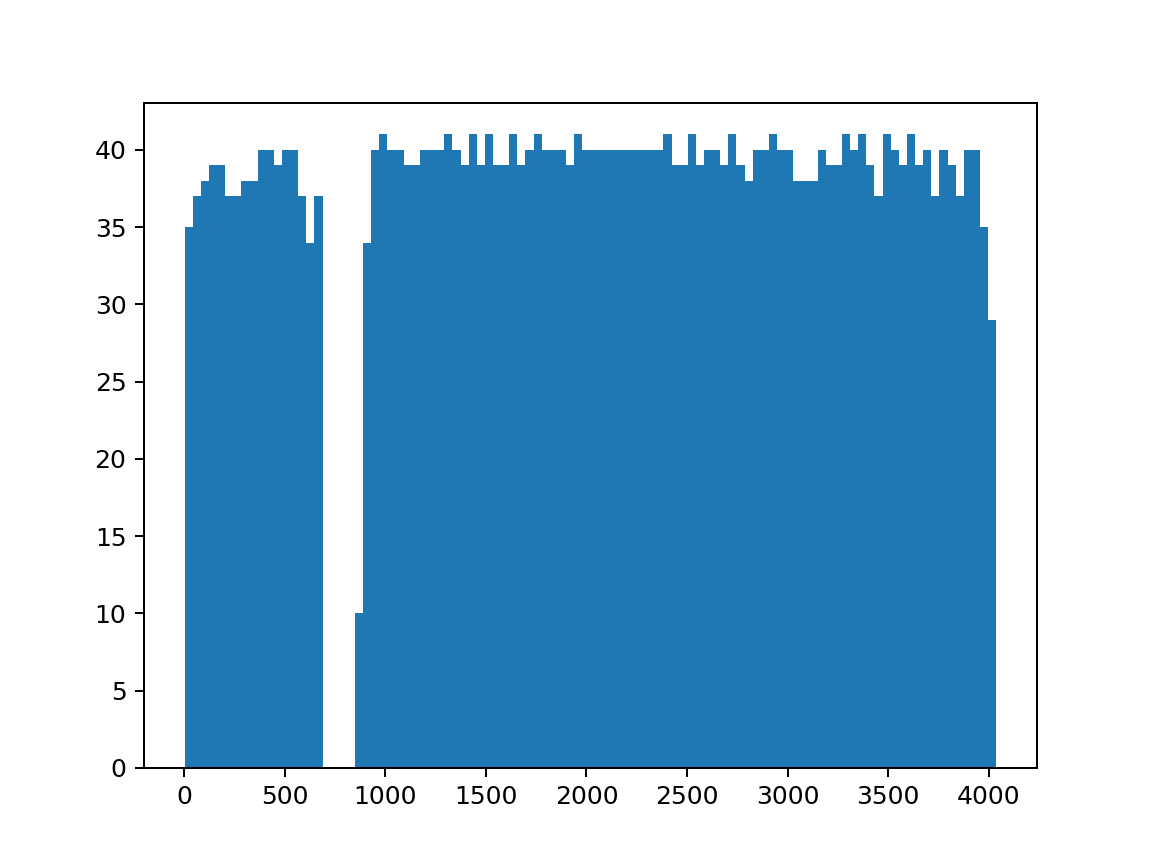

4038

In [537]:
degrees =  list(dict(G_m.degree()))
plt.figure()
plt.hist(degrees, bins = 100)
max(degrees)

# Graph metrics

## Centrality measures

In [3]:
# return neighbours of the given node
def neighbors(G, node):
    return (list(G.neighbors(node)))

In [539]:
eig_center = nx.eigenvector_centrality(G_m)
deg_center = nx.degree_centrality(G_m)
top_eig_center =dict(sorted(eig_center.items(), key = lambda x: x[1], reverse = True))
top_deg_center = dict(sorted(deg_center.items(), key = lambda x: x[1], reverse = True))

In [540]:
centralities = pd.DataFrame({'Degree': degrees, 'Eigenvalue': eig_center.values()})
centralities = centralities.sort_values(by = 'Eigenvalue',
                                          ascending = False
                                         )
targets = centralities[centralities['Degree']<10]
targets_neigh = [neighbors(G_m, node) for node in targets.index.tolist()]
targets_neigh  = [node for neigh in targets_neigh for node in neigh ]
G_t = nx.subgraph(G_m, targets_neigh)
plt.figure(figsize = (8,5))
nx.draw_networkx_nodes(G_t, pos= pos, node_size = 10, edgecolors = 'black')
nx.draw_networkx_edges(G_t,pos)

<IPython.core.display.Javascript object>

In [543]:
def sim_matrices(G, A):
    cos = np.zeros(A.shape)
    k=0
    Z = np.array([[0,1,0],
                 [1,0,1],
                 [1,1,1]])
    for i in range(A.shape[0]):
        for j in range(i+1):
            cos[i,j] = 1-cosine(A[:,i], A[:,j])
    cos = np.triu(cos.T, k=1) +cos
    return(A,cos)

In [546]:
top_eig = [node for node,_ in top_eig_center.items()]
top_deg = [node for node,_ in top_deg_center.items()]

In [547]:
color_map = {}
for node in G_m:
    if node in top_eig:
        color_map[node] = 'red';
    elif node in top_deg:
         color_map[node] = 'green'
    else:
        color_map[node] = 'blue'
color_map[2266]

'red'

# Ploting eigenvalue centralities  
The bigger centrality measure of the node, the larger is the node

<IPython.core.display.Javascript object>


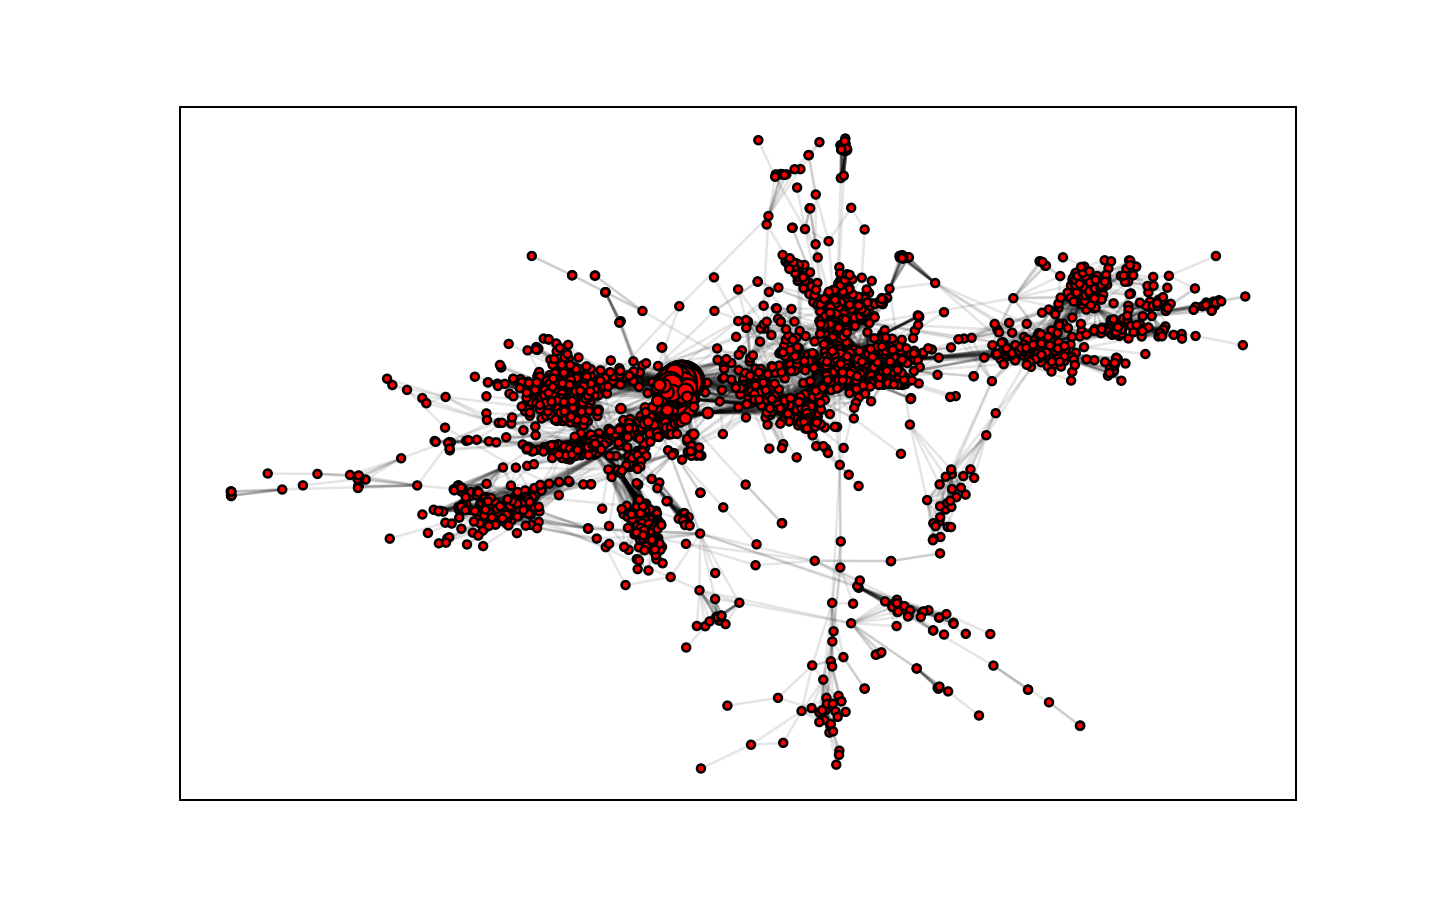

In [548]:
scale = 50
node_sizes = scale*np.array(list(eig_center.values()))
plt.figure(figsize = (8,5))
nx.draw_networkx_nodes(G_m, pos= pos, edgecolors = 'black', 
                       node_color = color_map.values(), 
                       node_size = scale*node_sizes + 10
                      )
nx.draw_networkx_edges(G_m,pos, alpha = 0.1)

## communities

In [549]:
communitites = Laplacian_eigenmaps(G_m, n_clusters = 8, n_components = 3)

<IPython.core.display.Javascript object>


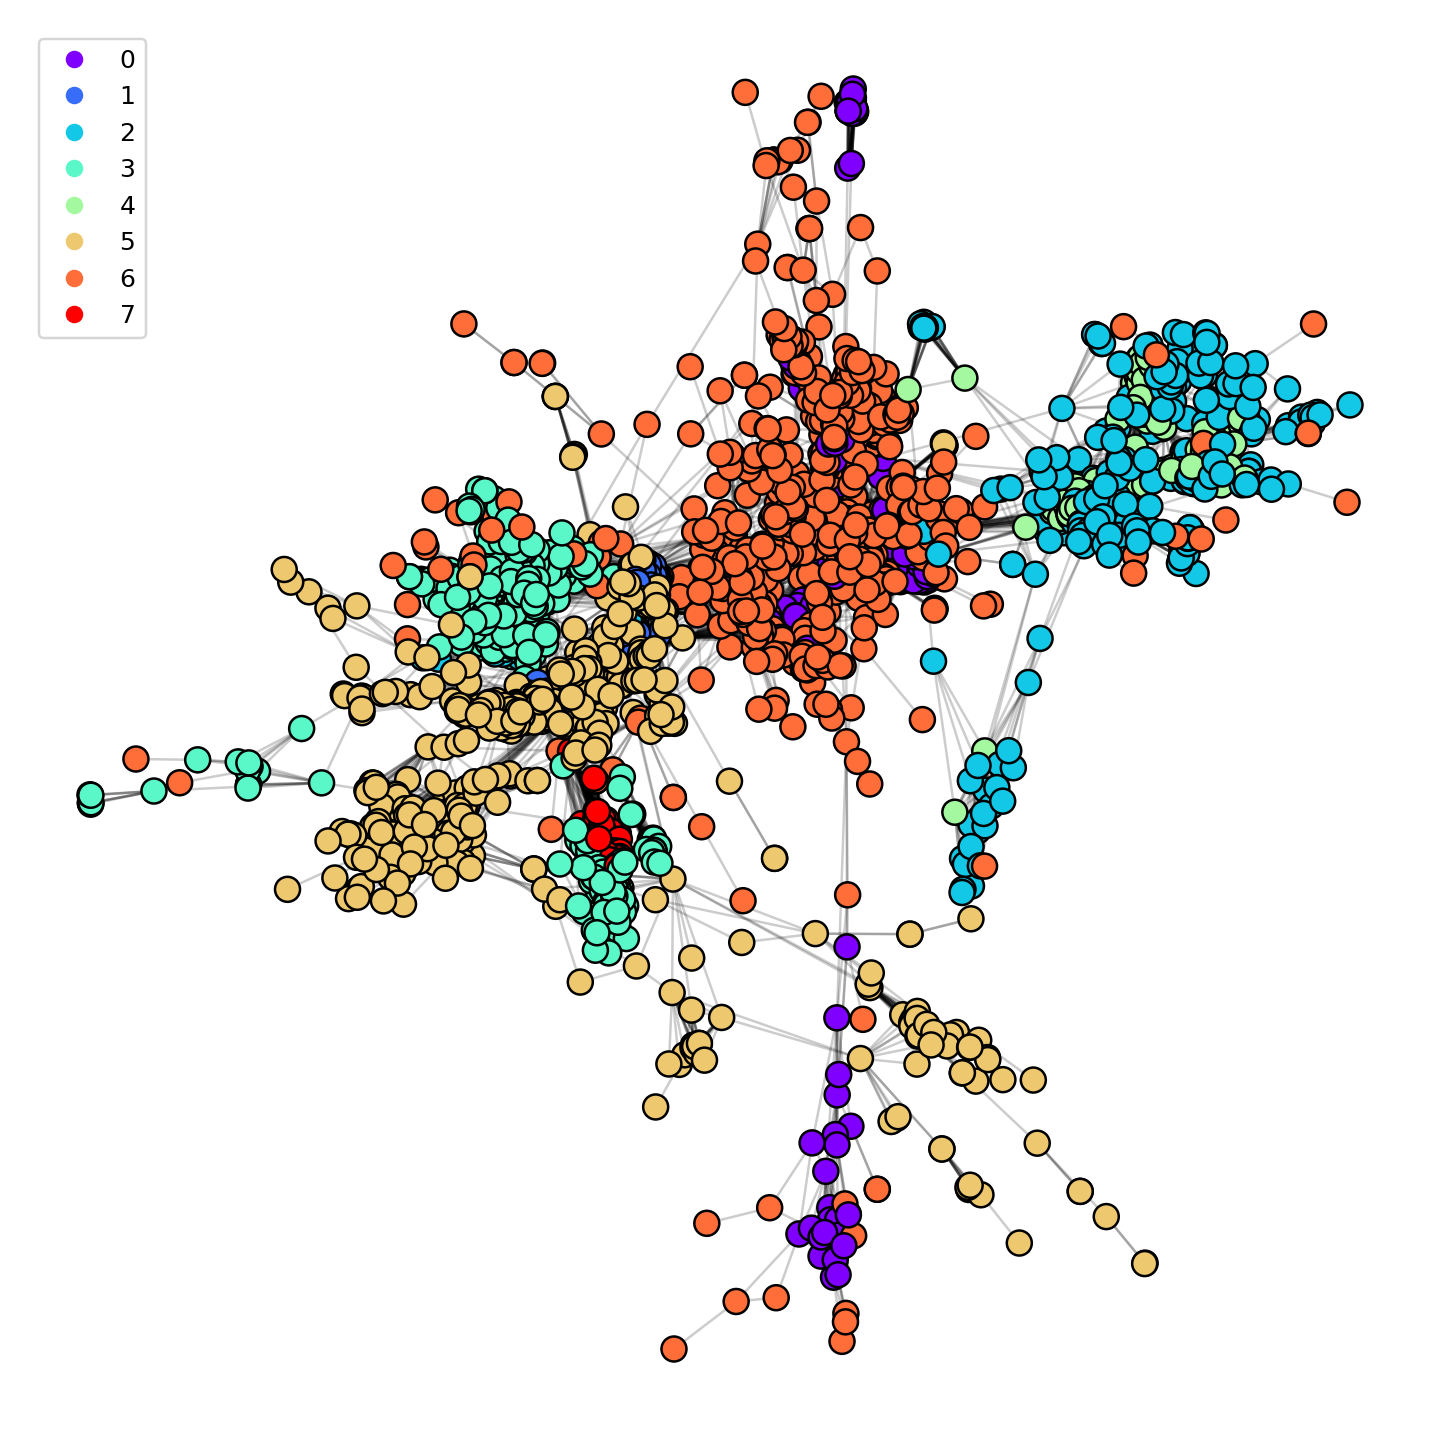

In [550]:
Laplacian_eigenmaps_fig(G_m,pos,n_clusters = 8, n_components =3, labels = None)

In [22]:
centralities

,Degree,Eigenvalue
1741,2266,8.751556e-02
2777,2206,8.671452e-02
2712,2233,8.569843e-02
2802,2464,8.493050e-02
2822,2218,8.478828e-02
...,...,...
3729,3992,2.327742e-18
3728,3983,1.261817e-18
3730,4036,4.112240e-19
386,241,1.037463e-19


# Node effectivity
Lets define effective nodes as such that beeing influenced give the biggest profit relatively to their price.

In [460]:
# узлы с наилучшим соотношением цена/прибыл
def effective_nodes(G):
    node_effectiveness = {}
    prices = cont_cost(G)
    for node in G:
        node_price = prices[node]
        node_neigh = neighbors(G, node)
        neigh_degs = [G.degree(node) for node in node_neigh]
        #checking how many neig can be affected
        num_affect = sum([1 for deg in neigh_degs if 1/deg >= 0.18])
        node_income = num_affect*0.05
        node_effectiveness[node] = node_income/node_price*100
        
    return node_effectiveness
      
def cont_cost(G):
    node_cost = {}
    for node in G:
        num_neigh = len(neighbors(G, node))
        node_cost[node] = 0.3*num_neigh
    return node_cost
hubs =  cont_cost(G_m)
eff = effective_nodes(G_m)
eff

{236: 0.0,
 186: 0.0,
 84: 0.0,
 62: 0.0,
 142: 0.0,
 252: 0.2604166666666667,
 169: 0.45045045045045046,
 280: 0.7936507936507938,
 257: 0.0,
 297: 0.0,
 303: 0.0,
 105: 0.0,
 276: 0.0,
 272: 0.0,
 88: 1.7543859649122806,
 271: 0.2314814814814815,
 13: 0.0,
 69: 0.0,
 133: 0.9803921568627453,
 30: 0.0,
 121: 1.5151515151515154,
 21: 0.2604166666666667,
 26: 0.0,
 304: 0.0,
 122: 0.2688172043010753,
 224: 0.0,
 314: 0.0,
 315: 0.30303030303030304,
 213: 0.43859649122807015,
 67: 0.0,
 318: 0.0,
 322: 0.4694835680751174,
 141: 0.0,
 25: 1.2254901960784315,
 1: 0.0,
 200: 0.0,
 248: 0.0,
 341: 0.0,
 109: 0.462962962962963,
 55: 0.0,
 199: 0.3623188405797102,
 223: 0.0,
 178: 1.388888888888889,
 345: 0.0,
 9: 0.0,
 277: 0.5208333333333334,
 325: 0.0,
 59: 0.925925925925926,
 123: 0.0,
 203: 0.2976190476190476,
 45: 0.0,
 104: 0.0,
 285: 0.7246376811594204,
 170: 0.7407407407407408,
 128: 0.0,
 221: 0.0,
 239: 0.2873563218390805,
 188: 0.0,
 323: 0.0,
 222: 1.6666666666666667,
 56: 0.43290

## Overall table of each nodes price, effectivity score and eigenvalue centrallity

In [462]:
centralities = pd.DataFrame({'Nodes': G_m.nodes(), 'Price': hubs.values(),'Effect':eff.values(), 'Eig':eig_center.values()})
centralities.set_index('Nodes', inplace = True)
centralities = centralities.sort_values(by = 'Effect',
                                          ascending = False)

afford_nodes = centralities[centralities['Price']<10]
afford_nodes

,Price,Effect,Eig
Nodes,,,
1105,0.9,16.666667,4.311058e-10
1002,0.9,16.666667,4.311058e-10
49,0.9,16.666667,1.666055e-17
1027,0.6,16.666667,4.310503e-10
401,0.3,16.666667,1.468329e-14
...,...,...,...
679,1.8,0.000000,1.580967e-08
1474,0.9,0.000000,1.997001e-10
3361,3.9,0.000000,2.269757e-07


# Marketing compaign simmulation
`Every day we make 10 random contracts, then wait until addversarial effect stops spreading, then update the status of the nodes (affected, not affected or signed) and repeat the process until we ran out of the budget. We put this algorithm in a loop of a 10000 iterartions and than compare the results of each node contracts' order. Than we choose such order in which we make contracts that gives us the best profit.`

In [514]:
def update_aff_nodes(contract_nodes, budget, prices, contracts_per_day, affect_nodes): 
    daily_contracts = contract_nodes[:contracts_per_day]
    can_buy = True
    signed_contract_nodes = []
    k=0
    for node in daily_contracts:
        node_price =  prices[node]
        if budget >= node_price:
            affect_nodes[node] = 1
            budget -= node_price
            signed_contract_nodes.append(node)
            k+=1
        else:
            can_buy = False
            break
    contract_nodes = contract_nodes[k:]
    return budget, contract_nodes, signed_contract_nodes, affect_nodes, can_buy

best_of_best = []
for _ in tqdm(range(10000),position = 0, leave = True):
    afford_nodes = list(np.random.permutation(G_m.nodes()))
    overall_strategy = []
    overall_affected = []
    contracts_per_day = 10
    prices = cont_cost(G_m)
    all_cascades = []
    for k in range(1,contracts_per_day+1):
        budget = 10
        income_pp = 0.05
        compaign_dur = 60
        strategy = {}
        day = 0
        can_buy = True
        affect_nodes = dict(zip(list(G_m.nodes), [0]*len(G_m)))
        visited_nodes = dict(zip(list(G_m.nodes), [0]*len(G_m)))
        cascades = {}
        #contract_nodes = afford_nodes.index.tolist()
        contract_nodes = afford_nodes
        while day < compaign_dur:
            budget, contract_nodes, new_contract_nodes, affect_nodes, can_buy = update_aff_nodes(contract_nodes, budget, prices, k, affect_nodes)
            if can_buy:
                strategy[day] = new_contract_nodes
                cascades[day] = np.array(list(affect_nodes.values()))
                for new_visit in new_contract_nodes:
                    visited_nodes[new_visit] = 1
                #print(k, day,budget,  sum(affect_nodes.values()))
                i = 1
                num_affect_nodes = sum(affect_nodes.values())
                new_affected_nodes = [-2,-1,num_affect_nodes]
                while new_affected_nodes[i] != new_affected_nodes[i-1] and day < compaign_dur:
                    all_aff_nodes = [n for n,a in affect_nodes.items() if a==1]
                    for node in all_aff_nodes:
                        for neig in neighbors(G_m, node):
                            affect_neig_num = sum([1 for n in neighbors(G_m, neig) if affect_nodes[n] == 1])/len(neighbors(G_m, neig)) * 100
                            if affect_neig_num > 18 and visited_nodes[neig] !=1:
                                affect_nodes[neig] = 1
                                visited_nodes[neig] = 1
                                budget+=income_pp
                    i+=1
                    new_affected_nodes.append(sum(affect_nodes.values()))
                    day+=1
                day-=2
            else:
                break

        overall_affected.append((sum(affect_nodes.values()), day))
        overall_strategy.append(strategy)
        all_cascades.append(cascades)

    max_aff = overall_affected[0][0]
    min_day = overall_affected[0][1]
    for i in range(len(overall_affected)):
        if overall_affected[i][0] >= max_aff and overall_affected[i][1] <= min_day:
            max_aff = overall_affected[i][0]
            min_day = overall_affected[i][1]
            best_arg = i

    best_strategy =  overall_strategy[best_arg]   
    with open('output.txt', 'w+') as f:
        f.write(str(best_strategy))
    best_of_best.append([overall_affected[best_arg], best_strategy])
    

100%|██████████| 10000/10000 [33:00<00:00,  5.05it/s]  


In [520]:
ans = max(best_of_best, key = lambda x: x[0][0])
with open('output.txt', 'w+') as f:
        f.write(str(ans[1]))  

[(712, 16), {0: [3057], 12: [362], 13: [894]}]

In [ ]:
sim = all_cascades[best_arg]
for i, (k,color) in enumerate(sim.items()):
    print(color)

In [530]:
neighbors(G_m, 3057)
[(node, G_m.degree(node)) for node in neighbors(G_m, 3057)]
deg_center[3057]

0.004288394532296971

# Plotting compaign effect propagation day-by-day 
Green graph nodes are unaffected, red are affected.

<IPython.core.display.Javascript object>


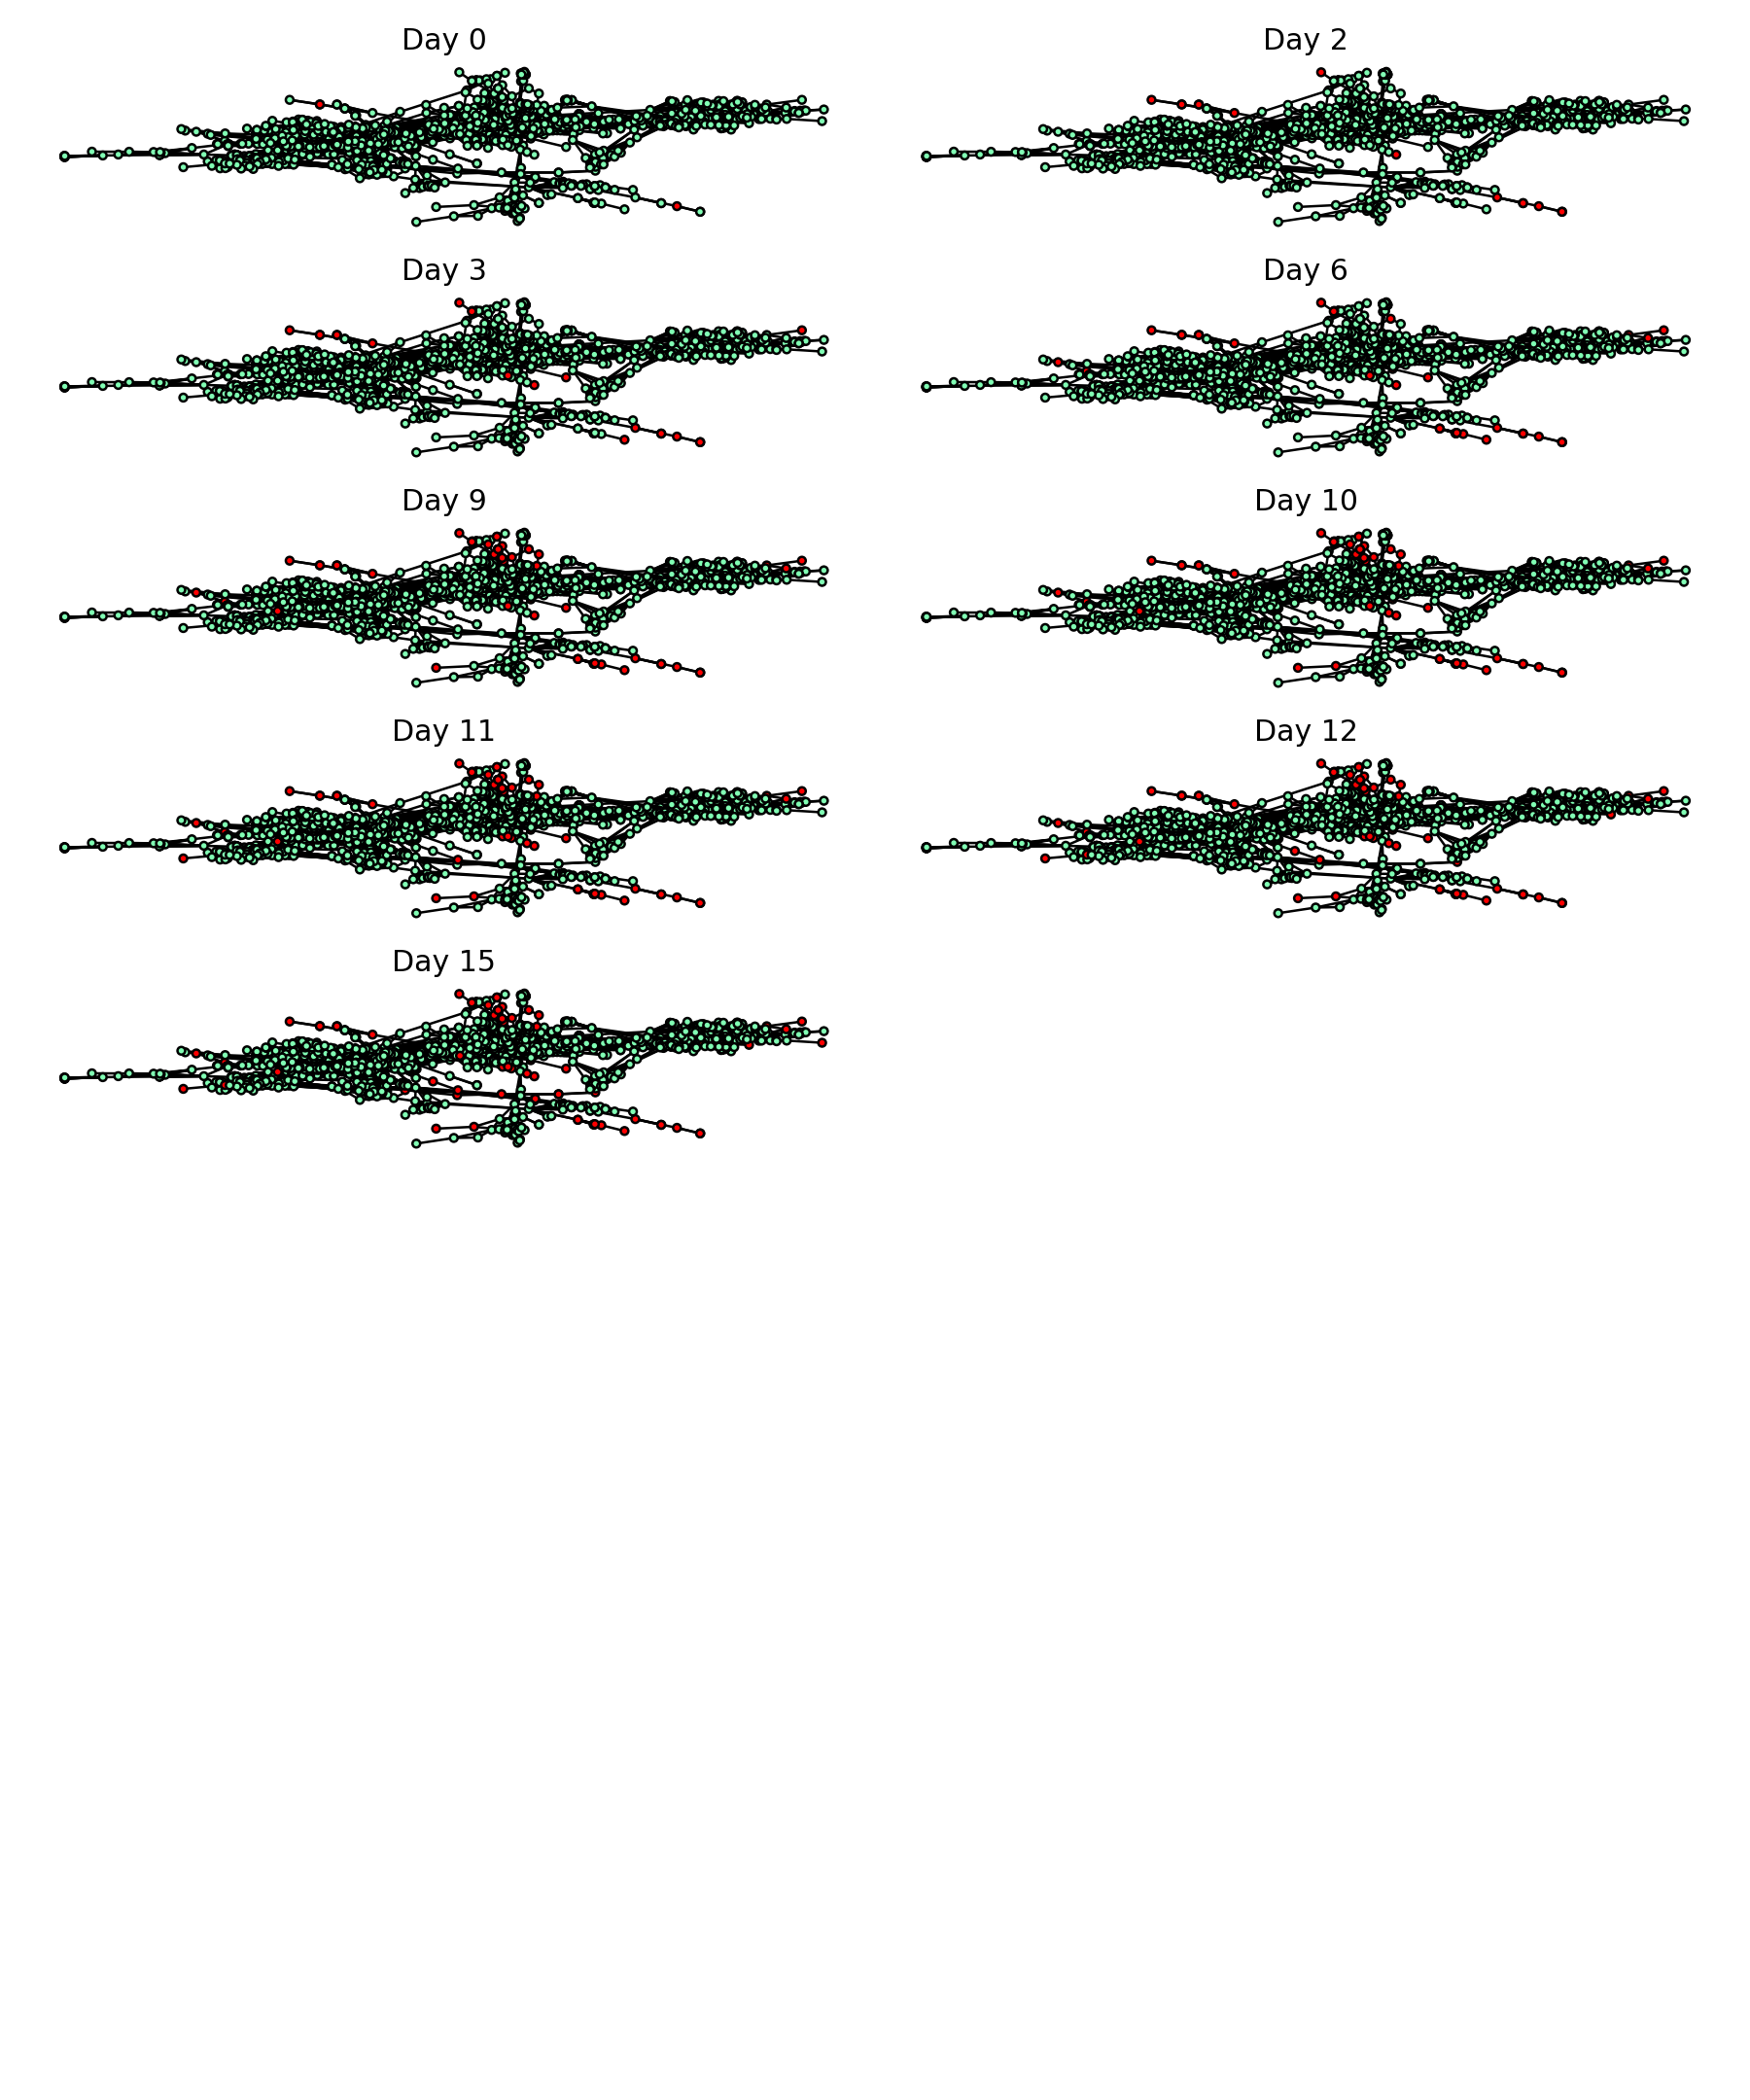

In [457]:
plt.figure(figsize=(5*2, 3*4))

for i, (k, color) in enumerate(sim.items()):
    plt.subplot(len(sim), 2, i+1)
    nx.draw(G_m, pos, with_labels=False, 
            node_color=color+1,
            node_size = 10,
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Day {}'.format(k))
plt.show()
plt.tight_layout()

In [ ]:
def update_aff_nodes(contract_nodes, budget, prices, contracts_per_day, affect_nodes): 
    daily_contracts = contract_nodes[:contracts_per_day]
    can_buy = True
    signed_contract_nodes = []
    k=0
    for node in daily_contracts:
        node_price =  prices[node]
        if budget >= node_price:
            affect_nodes[node] = 1
            budget -= node_price
            signed_contract_nodes.append(node)
            k+=1
        else:
            can_buy = False
            break
    contract_nodes = contract_nodes[k:]
    return budget, contract_nodes, signed_contract_nodes, affect_nodes, can_buy

def marketing_compaign(G,contract_nodes, init_budget = 10, income_pp = 0.05,  compaign_dur = 60, max_contracts_per_day = 10):
    overall_strategy = []
    overall_affected = []
    prices = cont_cost(G)
    for k in range(1,max_contracts_per_day+1):
        budget, income_pp,compaign_dur  = init_budget, income_pp,compaign_dur
        strategy = {}
        day = 0
        can_buy = True
        affect_nodes = dict(zip(list(G.nodes), [0]*len(G)))
        visited_nodes = dict(zip(list(G.nodes), [0]*len(G)))
        while day < compaign_dur:
            budget, contract_nodes, new_contract_nodes, affect_nodes, can_buy = update_aff_nodes(contract_nodes, budget, prices, k, affect_nodes)
            if can_buy:
                strategy[day] = new_contract_nodes
                print(day, sum(affect_nodes.values()))
                for new_visit in new_contract_nodes:
                    visited_nodes[new_visit] = 1
                #print(k, day,budget,  sum(affect_nodes.values()))
                i = 1
                num_affect_nodes = sum(affect_nodes.values())
                new_affected_nodes = [-2,-1,num_affect_nodes]
                while new_affected_nodes[i] != new_affected_nodes[i-1] and day < compaign_dur:
                    all_aff_nodes = [n for n,a in affect_nodes.items() if a==1]
                    for node in all_aff_nodes:
                        for neig in neighbors(G_m, node):
                            affect_neig_num = sum([1 for n in neighbors(G, neig) if affect_nodes[n] == 1])/len(neighbors(G, neig)) * 100
                            if affect_neig_num > 18 and visited_nodes[neig] !=1:
                                affect_nodes[neig] = 1
                                visited_nodes[neig] = 1
                                budget+=income_pp
                    i+=1
                    new_affected_nodes.append(sum(affect_nodes.values()))
                    day+=1
                day-=2
            else:
                break

        overall_affected.append((sum(affect_nodes.values()), day))
        overall_strategy.append(strategy)

  
    max_aff = overall_affected[0][0]
    min_day = overall_affected[0][1]
    for i in range(len(overall_affected)):
        if overall_affected[i][0] >= max_aff and overall_affected[i][1] <= min_day:
            max_aff = overall_affected[i][0]
            min_day = overall_affected[i][1]
            best_arg = i
    best_strategy =  overall_strategy[best_arg]   
    
    return (overall_affected,best_strategy )

#marketing_compaign(G_m, afford_nodes.index.tolist())